In [8]:
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

from random import sample
from math import ceil, sqrt

# Instance Construction

In [9]:
# Create a random planar graph:
graph = nx.convert_node_labels_to_integers(nx.triangular_lattice_graph(2, 2))
edges_to_remove = sample(list(graph.edges()), k=int(0.3 * graph.number_of_edges()))
graph.remove_edges_from(edges_to_remove)

# Read an input graph:
# graph = nx.read_edgelist('instances/planar_1.in', create_using=nx.Graph, nodetype=int)

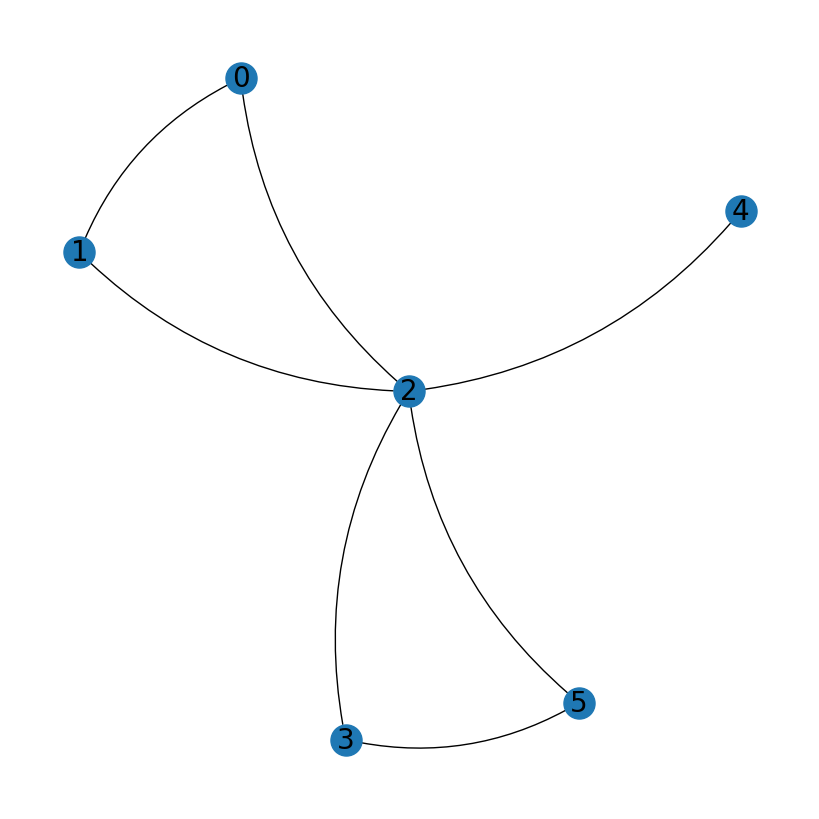

In [10]:
n = len(graph)
V = graph.nodes()
E = graph.edges()

# Plot the graph
plt.figure(figsize=(8, 8))
nx.draw(graph, with_labels=True, node_size=500, font_size=20, arrows=True, connectionstyle='arc3,rad=0.2')
plt.axis('equal')
plt.show()

# Create the Model

In [11]:
m = gp.Model('grid-drawing')

## Dimensions bounds:
WIDTH, HEIGHT = 10, 10

## Variables:
width = m.addVar(ceil(sqrt(n)) - 1, WIDTH, 0, GRB.INTEGER, 'w')
height = m.addVar(1, HEIGHT, 0, GRB.INTEGER, 'h')
x = m.addVars(V, lb=0, ub=WIDTH, vtype=GRB.INTEGER, name='x')
y = m.addVars(V, lb=0, ub=HEIGHT, vtype=GRB.INTEGER, name='y')
m.update()

m.addConstrs(((x[u] - x[v]) ** 2 + (y[u] - y[v]) ** 2 >= 1
              for u in V for v in V if u < v), name='diff')  # all used grid points are distinct
m.addQConstr((height + 1) * (width + 1) >= n, name='min_num')  # minimum number of grid points
m.addConstrs((x[i] <= width for i in V), name='x_bound')  # all x's must be within the bounding box
m.addConstrs((y[i] <= height for i in V), name='y_bound')  # all y's must be within the bounding box
m.addConstr(width >= height, name='lied_down')  # remove some symmetries by forcing a lied down box
m.update()

In [12]:
t1, t2 = {}, {}
act = {}
zero = m.addVar(0, 0, vtype=GRB.BINARY, name='zero')
for e in E:
    for f in E:
        if e < f and not set(e) & set(f):
            t1[e + f] = m.addVar(0, 1, 0, GRB.CONTINUOUS, f't1[{e[0]},{e[1]},{f[0]},{f[1]}]')
            t2[e + f] = m.addVar(0, 1, 0, GRB.CONTINUOUS, f't2[{e[0]},{e[1]},{f[0]},{f[1]}]')
            act[e + f] = m.addVar(0, 1, 1, GRB.BINARY, f'a[{e[0]},{e[1]},{f[0]},{f[1]}]')
            ax, bx, cx, dx = x[e[0]], x[e[1]], x[f[0]], x[f[1]]
            ay, by, cy, dy = y[e[0]], y[e[1]], y[f[0]], y[f[1]]
            te, tf = t1[e + f], t2[e + f]
            a = act[e + f]
            m.addConstr(zero == a * (ax * te + (1 - te) * bx) - a * (cx * tf + (1 - tf) * dx), f't1[{e[0]},{e[1]},{f[0]},{f[1]}]')
            m.addConstr(zero == a * (ay * te + (1 - te) * by) - a * (cy * tf + (1 - tf) * dy), f't2[{e[0]},{e[1]},{f[0]},{f[1]}]')
m.update()

# Model Solving

In [13]:
## Objective function:
m.setObjective(gp.quicksum(act.values()), GRB.MAXIMIZE)  # number of forced crossings
# m.setObjective(width + height, GRB.MINIMIZE)

## Solving:
try:
    m.optimize()
    print(f'\nFound a solution with bounding box {int(width.x)}x{int(height.x)}:')
    # Print coordinates for each node:
    for u in V():
        print(f'{u}: ({x[u].x:.2f}, {y[u].x:.2f})')

    # Save the model in a readable format:
    m.write('model.lp')

    # Print variable values after optimization
    print('\nVariables:')
    for var in m.getVars():
        if var.VarName[0] in ('t', 'a'): continue
        print(f'{var.VarName}: {var.X}')
except gp.GurobiError as e:
    print(f'Error code {e.errno}: {e}')
except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Freedesktop SDK 23.08 (Flatpak runtime)")

CPU model: AMD Ryzen 7 8845HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 13 rows, 36 columns and 26 nonzeros
Model fingerprint: 0x734069ef
Model has 16 quadratic constraints
Model has 14 general nonlinear constraints (84 nonlinear terms)
Variable types: 14 continuous, 22 integer (8 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 2e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [0e+00, 0e+00]
  QRHS range       [1e+00, 5e+00]
Presolve model has 14 nlconstr
Added 154 variables to disaggregate expressions.
Presolve removed 13 rows and 2 columns
Presolve time: 0.00s
Presolved: 507 rows, 259 columns, 1200 nonzeros
Presolved model has 98 bilinear c

# Visualize the computed solution

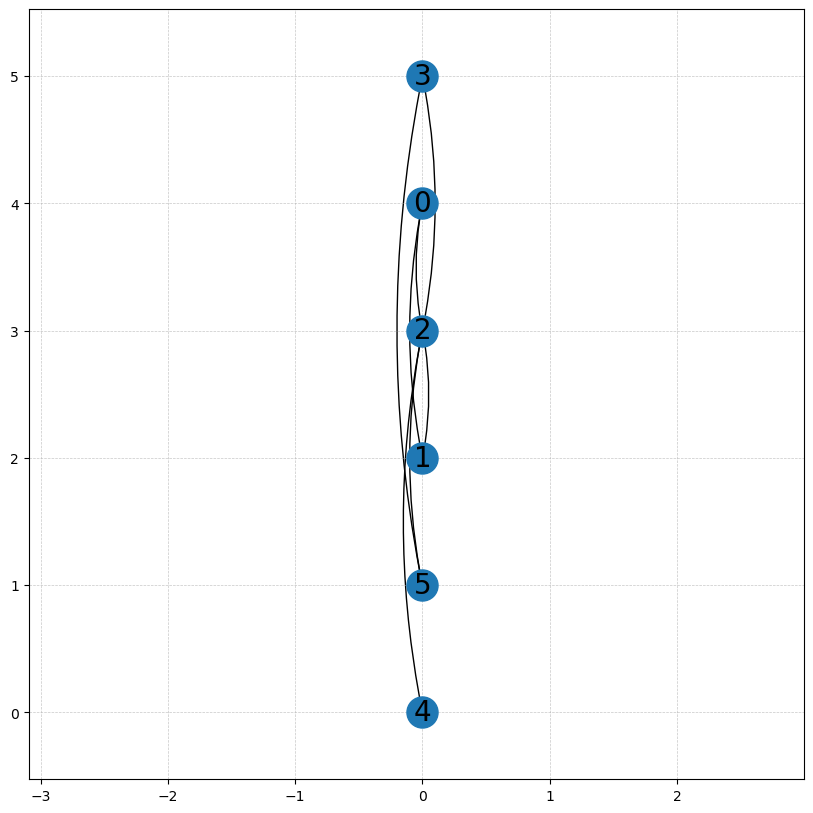

In [14]:
# Extract the coordinates:
pos = {node: (x[node].x, y[node].x) for node in V}

# Plot the graph with the positions obtained from the model:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(graph, pos=pos, with_labels=True, node_size=500, font_size=20, arrows=True, connectionstyle='arc3,rad=0.1', ax=ax)
plt.axis('on')
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.axis('equal')
plt.show()